In [20]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:

import glob

# Trova tutti i file csv che iniziano con 'datadump_'
file_paths = glob.glob('datadump_*.csv') 

# Caricali e uniscili in un colpo solo
data = pd.concat((pd.read_csv(f) for f in file_paths), ignore_index=True)

In [23]:
data.head()

,dateid,platform,gamemode,mapname,matchid,roundnumber,objectivelocation,winrole,endroundreason,roundduration,...,primarygrip,primaryunderbarrel,primarybarrel,secondaryweapon,secondaryweapontype,secondarysight,secondarygrip,secondaryunderbarrel,secondarybarrel,secondarygadget
0,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,1,STRIP_CLUB,Defender,AttackersKilledHostage,124,...,Vertical,NaN,Compensator,5.7_USG,Pistols,NaN,NaN,NaN,NaN,IMPACT_GRENADE
1,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,4,CHURCH,Defender,AttackersEliminated,217,...,Vertical,Laser,Suppressor,P12,Pistols,NaN,NaN,Laser,Suppressor,DEPLOYABLE_SHIELD
2,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,3,CHURCH,Defender,AttackersEliminated,160,...,NaN,NaN,NaN,MK1_9mm,Pistols,NaN,NaN,NaN,NaN,DEPLOYABLE_SHIELD
3,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,4,CHURCH,Defender,AttackersEliminated,217,...,NaN,NaN,MuzzleBrake,PRB92,Pistols,NaN,NaN,NaN,NaN,IMPACT_GRENADE
4,20170212,PC,HOSTAGE,CLUB_HOUSE,1522380841,6,BEDROOM,Attacker,DefendersEliminated,143,...,Vertical,Laser,Suppressor,P12,Pistols,NaN,NaN,Laser,Suppressor,DEPLOYABLE_SHIELD


In [24]:
data.columns

Index(['dateid', 'platform', 'gamemode', 'mapname', 'matchid', 'roundnumber',
       'objectivelocation', 'winrole', 'endroundreason', 'roundduration',
       'clearancelevel', 'skillrank', 'role', 'team', 'haswon', 'operator',
       'nbkills', 'isdead', 'primaryweapon', 'primaryweapontype',
       'primarysight', 'primarygrip', 'primaryunderbarrel', 'primarybarrel',
       'secondaryweapon', 'secondaryweapontype', 'secondarysight',
       'secondarygrip', 'secondaryunderbarrel', 'secondarybarrel',
       'secondarygadget'],
      dtype='object')

In [25]:
operatori = data['operator'].unique()
print(operatori)

print(f"\nTotale operatori trovati in questo campione: {len(operatori)}")

['SWAT-CASTLE' 'GSG9-JAGER' 'JTF2-FROST' 'BOPE-CAVEIRA' 'G.E.O.-JACKAL'
 'GIGN-TWITCH' 'SWAT-ASH' 'JTF2-BUCK' 'SPETSNAZ-FUZE' 'GSG9-IQ'
 'NAVYSEAL-BLACKBEARD' 'SPETSNAZ-TACHANKA' 'GSG9-BANDIT' 'G.E.O.-MIRA'
 'SAT-HIBANA' 'NAVYSEAL-VALKYRIE' 'SPETSNAZ-GLAZ' 'SAS-MUTE'
 'SWAT-THERMITE' 'SWAT-PULSE' 'GIGN-DOC' 'SAT-ECHO' 'SAS-SLEDGE'
 'GIGN-MONTAGNE' 'SWAT-RESERVE' 'SAS-SMOKE' 'GIGN-ROOK' 'GSG9-BLITZ'
 'SPETSNAZ-KAPKAN' 'GSG9-RESERVE' 'BOPE-CAPITAO' 'SAS-THATCHER'
 'GIGN-RESERVE' 'SAS-RESERVE' 'SPETSNAZ-RESERVE']

Totale operatori trovati in questo campione: 35


In [26]:
COLONNE_MAP = {
    'matchid': 'match_id',
    'roundnumber': 'round_id',
    'mapname': 'map_name',
    'objectivelocation': 'site_name',
    'role': 'role',
    'operator': 'operator',
    'haswon': 'is_round_won',
    'nbkills': 'kills',
    'isdead': 'deaths',
    'gamemode': 'game_mode',
}

# Filtra
colonne_esistenti = {k: v for k, v in COLONNE_MAP.items() if k in data.columns}
data_pulito = data[list(colonne_esistenti.keys())].rename(columns=colonne_esistenti).copy()

# Pulizia nome operatore
data_pulito['operator'] = data_pulito['operator'].apply(lambda x: x.split('-')[-1] if isinstance(x, str) and '-' in x else x)

# Mappa scelta
data_pulito = data_pulito[data_pulito['map_name'] == 'CLUB_HOUSE'].copy()

#Pulizie varie
data_pulito['unique_round_id'] = data_pulito['match_id'].astype(str) + '_' + data_pulito['round_id'].astype(str)
data_pulito = data_pulito[data_pulito['role'] == 'Attacker']
cols = ['unique_round_id'] + [c for c in data_pulito.columns if c != 'unique_round_id']
data_pulito = data_pulito[cols]
data_pulito = data_pulito.drop(columns=['match_id', 'round_id'])


# Raggruppamento
data_pulito = data_pulito.groupby('unique_round_id').agg(
    lineup=('operator', lambda x: list(x.unique())),
    victory=('is_round_won', 'max'),
    site_name=('site_name', 'first'),
    game_mode=('game_mode', 'first')
)
data_pulito = data_pulito.reset_index()

print(data_pulito.head(30))

data_pulito = data_pulito[data_pulito['lineup'].apply(len) == 5].copy()
data_pulito = data_pulito[data_pulito['site_name'].str.contains('-')].copy()

print(data_pulito.head(30))

# HOE Operatori
mlb = MultiLabelBinarizer()
X_ops = pd.DataFrame(mlb.fit_transform(data_pulito['lineup']),
                     columns=mlb.classes_,
                     index=data_pulito.index)


# HOE Site
X_site = pd.get_dummies(data_pulito['site_name'], prefix='site')


# Unione
X = pd.concat([X_ops, X_site], axis=1)
y = data_pulito['victory']


X.shape
X.head(10)
y.head(10)

   unique_round_id                                        lineup  victory  \
0     1000986941_1  [SLEDGE, BLACKBEARD, TWITCH, HIBANA, JACKAL]        1   
1     1000986941_2        [BUCK, MONTAGNE, HIBANA, THATCHER, IQ]        1   
2     1000986941_3     [SLEDGE, ASH, HIBANA, JACKAL, BLACKBEARD]        1   
3     1000986941_4           [IQ, TWITCH, THATCHER, ASH, JACKAL]        0   
4     1000986941_5     [ASH, SLEDGE, BLACKBEARD, JACKAL, TWITCH]        1   
5     1001006341_1            [JACKAL, HIBANA, THERMITE, SLEDGE]        1   
6     1001006341_2         [HIBANA, THERMITE, ASH, TWITCH, BUCK]        1   
7     1001006341_3            [HIBANA, TWITCH, SLEDGE, THERMITE]        0   
8     1001006341_4   [ASH, THERMITE, BLACKBEARD, HIBANA, TWITCH]        0   
9     1001006341_5       [THATCHER, HIBANA, THERMITE, ASH, BUCK]        1   
10    1001006341_6     [TWITCH, THERMITE, ASH, HIBANA, THATCHER]        1   
11    1001006341_7     [HIBANA, THATCHER, TWITCH, ASH, THERMITE]        1   

0     1
1     1
2     1
3     0
4     1
14    0
53    0
54    1
56    0
58    0
Name: victory, dtype: int64

In [27]:
# Let's scale
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#Ridge

grid = {'alpha': np.logspace(-6,3,30)}
def prob_err(y_true, y_pred):
  return np.mean(y_true * y_pred <= 0)
custom_scorer = make_scorer(prob_err, greater_is_better=False)
M = GridSearchCV(estimator  = RidgeClassifier(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'accuracy')
M.fit(X_train, y_train)
y_predict = M.predict(X_test)
acc = accuracy_score(y_test, y_predict)
perr = 100 * (1 - acc)
print(perr)
print(M.best_params_['alpha'])
print('%CM:\n ' +  str(confusion_matrix(y_test,y_predict)))

(9031, 20) (6021, 20) (9031,) (6021,)
43.08254442783591
1000.0
%CM:
 [[ 619 2069]
 [ 525 2808]]


In [43]:
grid = {
    'alpha': [0.01, 0.1, 1, 10],  # Quanto regolarizzare
    'kernel': ['rbf'],               # Kernel Non-Lineare
    'gamma': [0.001, 0.01, 0.1, 1]   # Quanto sono "curve" le decisioni
}

M = GridSearchCV(estimator  = KernelRidge(),
                 param_grid = grid,
                 cv         = 10,
                 scoring    = 'neg_mean_squared_error')
M.fit(X_train, y_train)
y_predict_continuous = M.predict(X_test)
# Convert continuous predictions to binary predictions using a threshold (e.g., 0.5)
y_predict = (y_predict_continuous > 0.5).astype(int)
acc = accuracy_score(y_test, y_predict)
perr = 100 * (1 - acc)
print(perr)
print(M.best_params_['alpha'], M.best_params_['gamma'])
print('%CM:\n ' +  str(confusion_matrix(y_test,y_predict)))

42.65072247135028
0.1 0.001
%CM:
 [[ 881 1807]
 [ 761 2572]]


In [30]:
#SVM

grid = {'C': np.logspace(-6,3,10),
        'kernel': ['linear']}
def prob_err(y_true, y_pred):
  return np.mean(y_true * y_pred <= 0)
custom_scorer = make_scorer(prob_err, greater_is_better=False)
M = GridSearchCV(estimator  = SVC(probability = True),
                 param_grid = grid,
                 cv         = 3,
                 scoring    = 'accuracy',
                 n_jobs     = -1)
M.fit(X_train, y_train)
y_predict = M.predict(X_test)
acc = accuracy_score(y_test, y_predict)
perr = 100 * (1 - acc)
print(perr)
print(M.best_params_['C'])
print('%CM:\n ' +  str(confusion_matrix(y_test,y_predict)))

KeyboardInterrupt: 

In [14]:
#SVM non linear

fast_grid = {
    'C': [0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': [0.1, 0.01, 0.001, 'scale']
}

grid = {'C': np.logspace(-6,3,10),
        'kernel': ['rbf'],
        'gamma': np.logspace(-6,3,10)}

M = GridSearchCV(estimator  = SVC(probability = True),
                 param_grid = fast_grid,
                 cv         = 3,
                 scoring    = 'accuracy',
                 n_jobs     = -1)
M.fit(X_train, y_train)
y_predict = M.predict(X_test)
acc = accuracy_score(y_test, y_predict)
perr = 100 * (1 - acc)
print(perr)
print(M.best_params_['C'], M.best_params_['gamma'])
print('%CM:\n ' +  str(confusion_matrix(y_test,y_predict)))

43.188137164040775
1 0.1
%CM:
 [[110 378]
 [ 88 503]]


In [15]:
print(f"Righe totali (X): {X.shape[0]}")
print(f"Righe usate per l'addestramento (X_train): {X_train.shape[0]}")
print(f"Colonne (Feature): {X_train.shape[1]}")

Righe totali (X): 5391
Righe usate per l'addestramento (X_train): 4312
Colonne (Feature): 20


Migliori parametri RF: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}

% Errore RF: 44.02%
Accuratezza RF: 55.98%
Matrice di Confusione:
 [[170 318]
 [157 434]]

--- TOP 10 OPERATORI CHE DECIDONO IL MATCH ---
                   Operatore  Importanza
5                       FUZE    0.060640
17  site_CCTV_ROOM-CASH_ROOM    0.059813
0                        ASH    0.059109
9                     JACKAL    0.058660
7                     HIBANA    0.057913
10                  MONTAGNE    0.056739
3                       BUCK    0.056228
18  site_CHURCH-ARSENAL_ROOM    0.055703
4                    CAPITAO    0.053866
14                  THERMITE    0.052946


C:\Users\luigi\AppData\Local\Temp\ipykernel_22252\501539294.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importanza', y='Operatore', data=feature_imp_df, palette='viridis')


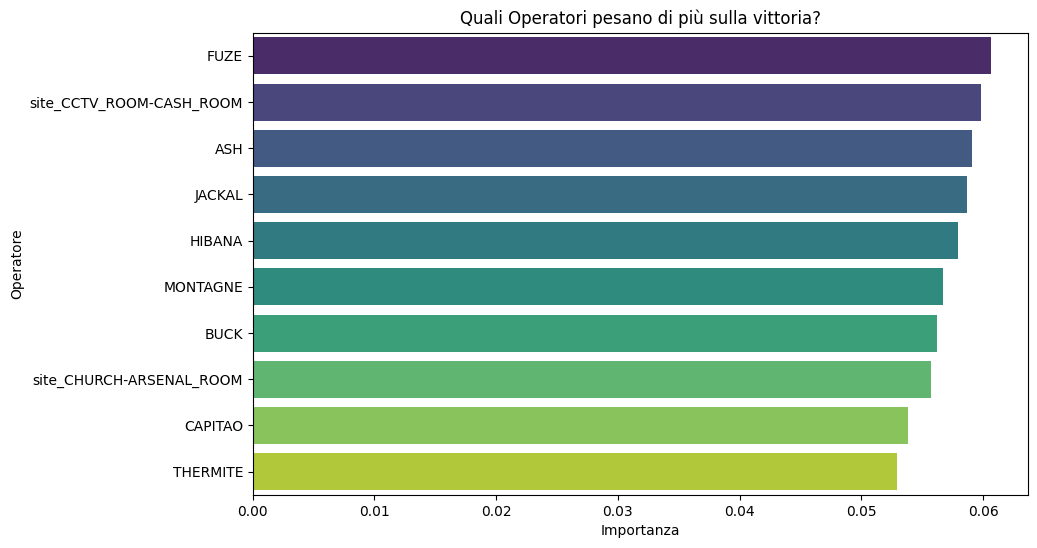


--- CLASSIFICA REALE DEGLI OPERATORI (Senza Siti) ---
   Operatore  Importanza
5       FUZE    0.060640
0        ASH    0.059109
9     JACKAL    0.058660
7     HIBANA    0.057913
10  MONTAGNE    0.056739
3       BUCK    0.056228
4    CAPITAO    0.053866
14  THERMITE    0.052946


In [21]:
grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20, None],       # None = scendi finché serve (rischioso ma potente)
    'min_samples_split': [2, 10],      # Non creare regole per gruppi troppo piccoli
    'max_features': ['sqrt']
}

M = GridSearchCV(estimator  = RandomForestClassifier(),
                 param_grid = grid,
                 cv         = 3,
                 scoring    = 'accuracy',
                 n_jobs     = -1)
M.fit(X_train, y_train)


# 3. Risultati
print(f"Migliori parametri RF: {M.best_params_}")

y_pred_rf = M.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
perr_rf = 100 * (1 - acc_rf)

print(f"\n% Errore RF: {perr_rf:.2f}%")
print(f"Accuratezza RF: {acc_rf:.2%}")

# 4. Matrice di Confusione
cm = confusion_matrix(y_test, y_pred_rf)
print('Matrice di Confusione:\n', cm)

# 5. BONUS: IMPORTANZA DELLE FEATURE (Cosa guarda il modello?)
# Questo ti dice se il modello ha "capito" il gioco o se guarda operatori a caso.
best_rf = M.best_estimator_
importances = best_rf.feature_importances_
feature_names = X.columns

# Creiamo un DataFrame per visualizzarlo
feature_imp_df = pd.DataFrame({'Operatore': feature_names, 'Importanza': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importanza', ascending=False).head(10)

print("\n--- TOP 10 OPERATORI CHE DECIDONO IL MATCH ---")
print(feature_imp_df)

# Grafico veloce
plt.figure(figsize=(10, 6))
sns.barplot(x='Importanza', y='Operatore', data=feature_imp_df, palette='viridis')
plt.title('Quali Operatori pesano di più sulla vittoria?')
plt.show()
top_operators_only = feature_imp_df[~feature_imp_df['Operatore'].str.contains('site_')]

print("\n--- CLASSIFICA REALE DEGLI OPERATORI (Senza Siti) ---")
print(top_operators_only.head(10))